<a href="https://www.kaggle.com/code/aisuko/eda-embeddings-datasets?scriptVersionId=175066584" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview



In [1]:
!pip install -U -q pyod==1.1.3
!pip install -U -q prince==0.13.0

In [2]:
import pandas as pd
import numpy as np

# Data visualization
import plotly.express as px
import prince

def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()

In [3]:
df=pd.read_csv("/kaggle/input/banking-dataset-marketing-targets/train.csv", sep=";")
df=df.iloc[:, 0:8]

In [4]:
df_embedding=pd.read_csv("/kaggle/input/transform-dataset-to-embeddings/banking-dataset-marketing-targets.csv", sep=",")

# Outliers

In [5]:
from pyod.models.ecod import ECOD


clf = ECOD()
clf.fit(df_embedding)


out = clf.predict(df_embedding) 
df_embedding["outliers"] = out
df["outliers"]=out

df_embedding_no_out = df_embedding[df_embedding["outliers"] == 0]
df_embedding_no_out = df_embedding_no_out.drop(["outliers"], axis = 1)


df_embedding_with_out = df_embedding.copy()
df_embedding_with_out = df_embedding_with_out.drop(["outliers"], axis = 1)

In [6]:
print(df_embedding_no_out.shape)
print(df_embedding_with_out.shape)

(40690, 384)
(45211, 384)


# Instantiate the clustering model and visualizer

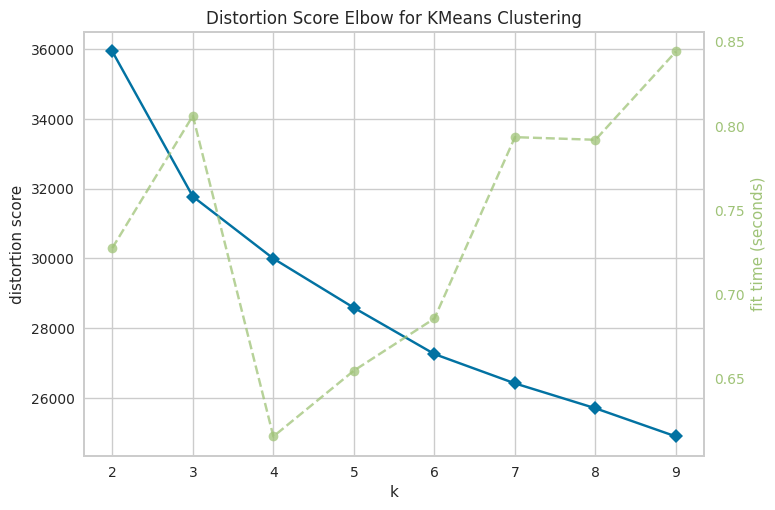

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), locate_elbow=False)
 
visualizer.fit(df_embedding_with_out)        # Fit the data to the visualizer
visualizer.show()       

# Checking best number of Clusters

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [8]:
# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# sk
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples
)

def make_Silhouette_plot(X, n_clusters):
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )
# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
        plt.xlabel("The silhouette coefficient values", fontsize=24)
        plt.ylabel("Cluster label", fontsize=24)
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.yticks([])  
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
range_n_clusters = list(range(2,10))
for n_clusters in range_n_clusters:
    print(f"N cluster: {n_clusters}")
    make_Silhouette_plot(df_embedding_no_out, n_clusters)   
    plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
    plt.close()

N cluster: 2
For n_clusters = 2 The average silhouette_score is : 0.16014948989765235
N cluster: 3
For n_clusters = 3 The average silhouette_score is : 0.15884164145593507
N cluster: 4
For n_clusters = 4 The average silhouette_score is : 0.12933797010899808
N cluster: 5
For n_clusters = 5 The average silhouette_score is : 0.1417814313775322
N cluster: 6
For n_clusters = 6 The average silhouette_score is : 0.13560534679830977
N cluster: 7
For n_clusters = 7 The average silhouette_score is : 0.13237057114905496
N cluster: 8
For n_clusters = 8 The average silhouette_score is : 0.12502297510656954
N cluster: 9
For n_clusters = 9 The average silhouette_score is : 0.12783284699571854


In [9]:
n_clusters=5

clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(df_embedding_no_out)
print(clusters.inertia_)
clusters_predict = clusters.predict(df_embedding_no_out)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


23784.337753518863


# Evaluation

In [10]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(df_embedding_no_out,clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(df_embedding_no_out,clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(df_embedding_no_out,clusters_predict)}")

Davies bouldin score: 2.1373252240469585
Calinski Score: 5108.997828797706
Silhouette Score: 0.1417790128893006


In [11]:
pca_3d_object, df_pca_3d = get_pca_3d(df_embedding_no_out, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0             60.215        15.68%                     15.68%
1             51.598        13.44%                     29.12%
2             38.587        10.05%                     39.17%


In [12]:
pca_2d_object, df_pca_2d = get_pca_2d(df_embedding_no_out, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.2)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# TSNE 3D

In [13]:
# from sklearn.manifold import TSNE

# sampling_data = df_embedding_no_out.sample(frac=0.5, replace=True, random_state=1)
# sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

# df_tsne_3d = TSNE(
#                   n_components=3, 
#                   learning_rate=500, 
#                   init='random', 
#                   perplexity=200, 
#                   n_iter = 5000).fit_transform(sampling_data)

# df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
# df_tsne_3d["cluster"] = sampling_clusters
# plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1, width_line = 0.1)

In [14]:
# plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=0.1, width_line = 0.1)

# TSNE 2d

In [15]:
# df_tsne_2d = TSNE(
#                   n_components=2, 
#                   learning_rate=500, 
#                   init='random', 
#                   perplexity=200, 
#                   n_iter = 5000).fit_transform(sampling_data)

# df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
# df_tsne_2d["cluster"] = sampling_clusters

# plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=0.5, width_line = 0.5)

In [16]:
# plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)

# Explanations

In [17]:
df_no_outliers = df[df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop("outliers", axis = 1)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 8
[LightGBM] [Info] Start training from score -1.308906
[LightGBM] [Info] Start training from score -1.619317
[LightGBM] [Info] Start training from score -1.427178
[LightGBM] [Info] Start training from score -2.391453
[LightGBM] [Info] Start training from score -1.607596


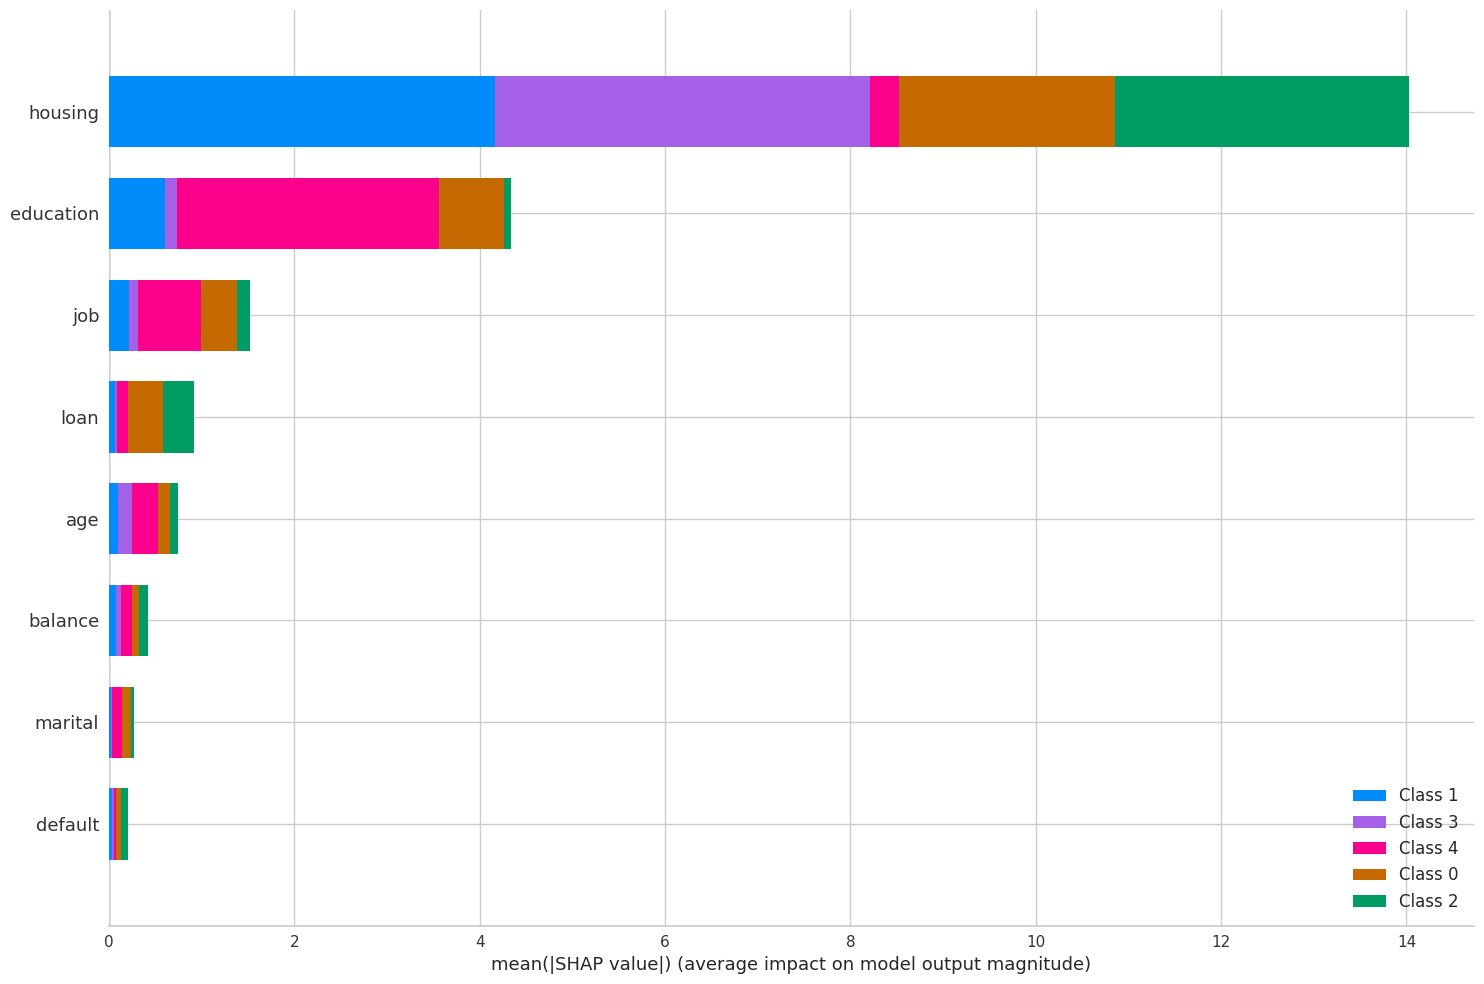

In [18]:
import lightgbm as lgb
import shap

clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

for col in ["job", "marital", "education", "housing", "loan", "default"]:
    df_no_outliers[col] = df_no_outliers[col].astype('category')

clf_km.fit(X = df_no_outliers , y = clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers)
shap.summary_plot(shap_values_km, df_no_outliers, plot_type="bar", plot_size=(15, 10))

In [19]:
from sklearn.metrics import accuracy_score,classification_report

y_pred = clf_km.predict(df_no_outliers)
accuracy=accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
Training-set accuracy score: 0.7152
              precision    recall  f1-score   support

           0       0.64      0.82      0.72     10991
           1       0.76      0.95      0.84      8058
           2       0.64      0.36      0.46      9765
           3       0.76      0.24      0.36      3723
           4       0.82      0.99      0.89      8153

    accuracy                           0.72     40690
   macro avg       0.72      0.67      0.66     40690
weighted avg       0.71      0.72      0.68     40690



# Check Cluster Info

In [20]:
df_no_outliers["cluster"] = clusters_predict

df_group = df_no_outliers.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],
        
    }
).sort_values("job").reset_index()
df_group

,cluster,job,marital,education,housing,loan,age,balance,default
0,0,blue-collar,married,secondary,yes,no,38.976890,1077.598490,no
1,2,blue-collar,married,secondary,yes,no,39.574398,1050.799693,no
2,3,blue-collar,married,secondary,no,no,45.033038,1409.050766,no
3,4,management,married,tertiary,no,no,38.495033,1722.481173,no
4,1,technician,married,secondary,no,no,42.869198,1440.349590,no


# Acknowledge
* https://github.com/damiangilgonzalez1995/Clustering-with-LLM/blob/main/embedding.ipynb
* https://towardsdatascience.com/mastering-customer-segmentation-with-llm-3d9008235f41#3a33